In [149]:
import pandas as pd
import nltk, os, numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
import string
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

STOP_WORDS=set(stopwords.words('english') + list(string.punctuation))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mihat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mihat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mihat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Read and prepare data for further work

In [3]:
df = pd.read_csv('full_dataset_all_labels.csv')
df = df.sample(10000)

In [7]:
def tokenize(text):
    #print(text)
    text = preprocess_text(text)
    #print(text)
    tokens = word_tokenize(text)
    filtered_tokens = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation). (adapted from lab example)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens
    

def preprocess_text(text):
    text = re.sub(r"http\S+", " ", text)            # remove urls
    text = re.sub('<USER>', '', text)               # remove '<USER>' as there are some such strings as user or url is masked with this string
    text = re.sub('<URL>', '', text)
    text = re.sub('[^a-zA-Z]', ' ', text)           # Remove punctuations
    text = text.lower()                             # Convert to lowercase
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)#remove tags
    text = re.sub("(\\d|\\W)+"," ",text)            # remove special characters and digits
    return text
    
    
def stemming(tokens):
    stemmer = SnowballStemmer("english")
    stems = [stemmer.stem(token) for token in tokens if (token not in STOP_WORDS)]
    return stems

from nltk.stem import WordNetLemmatizer
def lemmatizing(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmas

In [8]:
df['preprocessed_text']=df['text'].apply(preprocess_text)
df['tokenized_text']= df['text'].apply(tokenize) 
df['stems']= df['tokenized_text'].apply(stemming) 

In [13]:
labels = df['label'].unique()
df.sample(5)

,text,label,preprocessed_text,tokenized_text,stems
3135,you fucking retards are so ass backwards but i...,abuse,you fucking retards are so ass backwards but i...,"[you, fucking, retards, are, so, ass, backward...","[fuck, retard, ass, backward, guess, happen, b..."
40559,@CM_UTLR your man looks terrified in that pict...,offensive,cm utlr your man looks terrified in that pict...,"[cm, utlr, your, man, looks, terrified, in, th...","[cm, utlr, man, look, terrifi, pictur, beat, t..."
60034,RT @BernardGaynor: Islamic immigration is alre...,racist,rt bernardgaynor islamic immigration is alread...,"[rt, bernardgaynor, islamic, immigration, is, ...","[rt, bernardgaynor, islam, immigr, alreadi, le..."
14092,fuck off you racist cunt go fuck a sheep,homophobic,fuck off you racist cunt go fuck a sheep,"[fuck, off, you, racist, cunt, go, fuck, a, sh...","[fuck, racist, cunt, go, fuck, sheep]"
55089,Them hoes don't like me &#128514;&#128514;&#12...,offensive,them hoes don t like me,"[them, hoes, don, t, like, me]","[hoe, like]"


### CREATE UPSET PLOT

In [14]:
import upsetplot

Find top words for each category

In [88]:
k = 10
top_k_dict = {}
words_by_label_string = {}

for label in labels:
    tmp = df[df['label'] == label]['stems']
    tmp = tmp.apply(pd.Series).stack().reset_index(drop=True)
    words_by_label_string[label] = ' '.join(list(tmp.values))
    tmp = tmp.value_counts(normalize=True)[:k]
    top_k_dict[label] = tmp

Create list of all words that are in the top k words. 

In [70]:
all_top_words = []
for k,v in top_k_dict.items():
    all_top_words = [*all_top_words , *v.index]

all_top_words = list(set(all_top_words))

Create dataframe where each column is label and each row represents the word in top words, values are True/False, depends on if word is top in selected label.

In [71]:
upset_df = pd.DataFrame()
col_names = labels

for i, col in enumerate(labels):
    temp = []
    for w in all_top_words:
        if w in top_k_dict[col].index:
            temp.append(True)
        else:
            temp.append(False)
    upset_df[col] = temp
    
upset_df['c'] = 1
example = upset_df.groupby(labels.tolist()).count().sort_values('c')
example

c
racist offensive obscene sexist slur  homophobic profane hateful abuse harassment vulgar insult hostile severe_toxic identity_hate cyberbullying threat    
False  False     False   False  True  True       False   False   False False      False  False  False   False        False         False         False    1
True   True      False   True   False False      False   True    False True       False  False  False   False        False         False         False    1
False  False     False   False  True  True       False   False   True  False      False  True   False   False        False         False         False    1
                         True   False False      False   False   False False      False  False  True    False        False         False         False    1
                                                 True    False   False True       True   False  True    False        False         False         False    1
                 True    False  False False      False   False   False False      False  False  False   False        True          False         False    1
                                                                                         True   False   True         True          False         False    1
                                                                                  True   True   False   False        True          False         False    1
                                                         True    False True       False  True   False   False        True          False         False    1
                                      True       False   True    False False      False  False  False   True         True          False         False    1
                                True  True       True    False   True  False      True   True   True    False        False         False         True     1
                 False   False  True  False      False   False   False True       False  False  False   False        False         False         False    1
       True      False   False  False False      False   False   True  False      False  False  False   True         False         True          False    1
                                                         True    False False      True   False  False   True         False         True          False    1
                         True   False False      False   False   False False      False  True   False   False        False         False         False    1
                                True  True       True    True    True  False      True   True   True    False        False         True          False    1
                 True    False  True  False      False   True    False True       True   True   False   True         False         True          False    1
                                      True       False   False   True  False      True   False  False   True         False         False         False    1
                                                 True    True    True  True       True   True   True    True         True          True          True     1
True   False     False   False  False False      False   False   False True       False  False  False   False        False         False         False    1
                                                                                         True   False   False        False         False         False    1
                                      True       False   True    True  True       False  False  True    False        False         False         False    1
                         True   True  False      True    False   False False      True   False  False   False        False         True          False    1
False  True      False   False  False False      False   True    False False      False  False  False   False        False         False         False    1
       False     False   False  True  False      False   False   False False      False  False  Fa

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

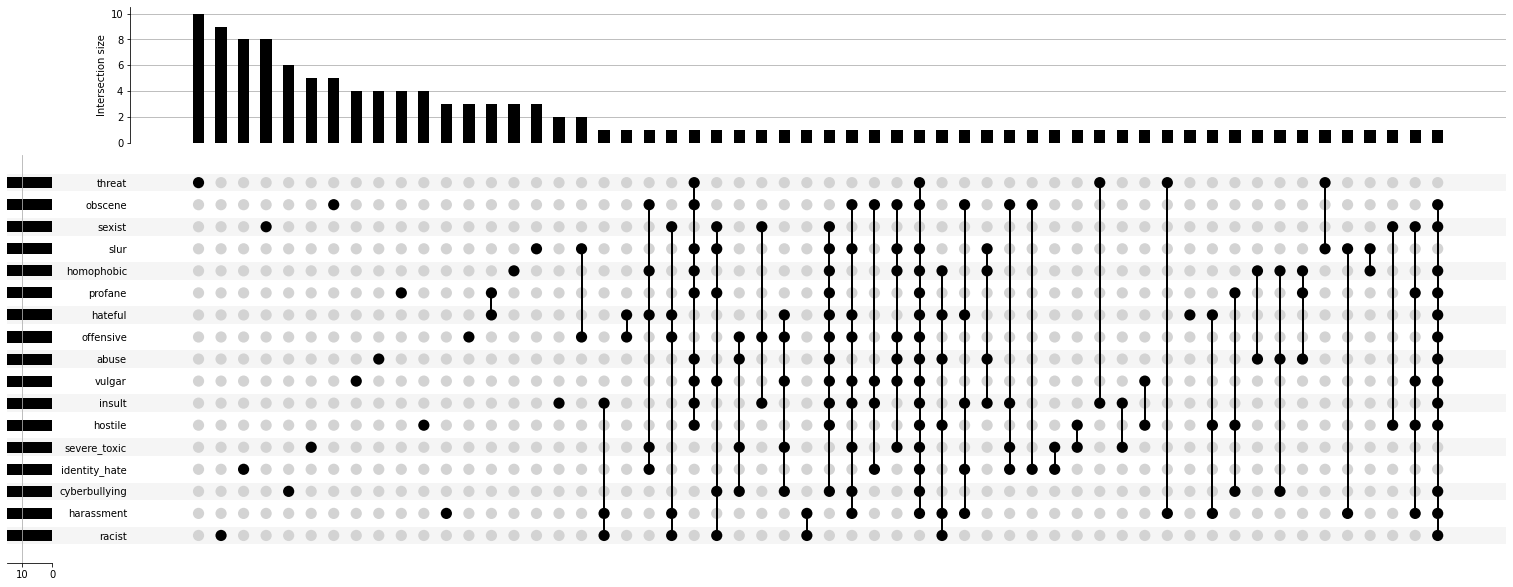

In [72]:
upsetplot.plot(example['c'], sort_by="cardinality")

## TFIDF TRY

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Create tfidf vectorizer and fit it on all data.

In [133]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(list(words_by_label_string.values()))
df_tfidf = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df_tfidf = df_tfidf.sort_values('TF-IDF', ascending=False)

Array where each row represents one label and each column is certain word, (i,j) rating for j-th word in t-th document.

In [102]:
tfidf_array = tfIdf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00121669, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [111]:
cosine_similarities = cosine_similarity(tfidf_array)
df_similar = pd.DataFrame(cosine_similarities, columns = labels, index = labels)

<AxesSubplot:>

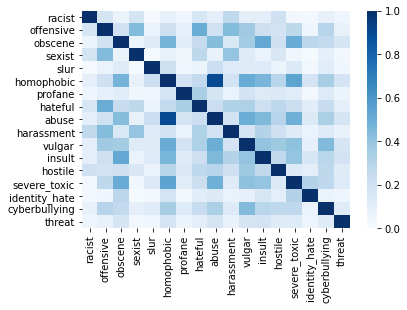

In [118]:
sns.heatmap(df_similar, vmin=0, vmax=1, cmap='Blues')

## VIZUALIZATION OF FEW RANDOM DOCUMENTS

In [120]:
from yellowbrick.text import TSNEVisualizer,UMAPVisualizer

In [168]:
def visualize_tfidf_tsne(corpus_data,corpus_target,labels = True,alpha=0.9,metric=None):
    docs   = tfIdfVectorizer.transform(corpus_data)
    
    if labels is True:
        labels = corpus_target
    else:
        labels = None
    viz = TSNEVisualizer(alpha = alpha, colors = [plt.cm.gist_ncar(i) for i in np.linspace(0,0.9, len(set(labels)))])
    viz.fit(docs,labels)
    return viz.poof()

In [143]:
corpus = df[['label', 'stems']].sample(1000)
corpus['stems'] = corpus['stems'].apply(lambda x: ' '.join(x))
corpus_target = list(corpus['label'])
corpus_data = list(corpus['stems'])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

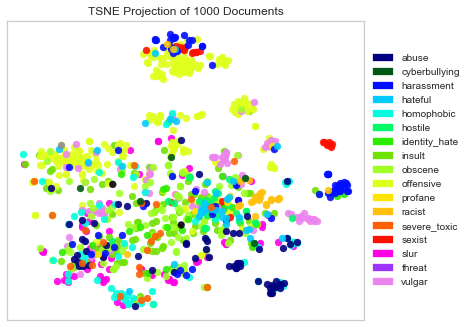

<AxesSubplot:title={'center':'TSNE Projection of 1000 Documents'}>

In [169]:
visualize_tfidf_tsne(corpus_data,corpus_target)